In [1]:
import pandas as pd
import matplotlib as mp

%matplotlib inline

In [2]:
auctions = pd.read_csv('../data/auctions.csv.gzip',compression='gzip',\
                        usecols=['date','device_id','platform','ref_type_id','source_id'],\
                        dtype={'device_id':'int64','platform':'category','ref_type_id':'category','source_id':'category'},\
                        parse_dates=['date'])

## Cada 3 dias, cuantas veces aparece un mismo id en promedio?

In [3]:
auctions.head()

,date,device_id,platform,ref_type_id,source_id
0,2019-03-11 14:18:33.290763,6059599345986491085,1,1,0
1,2019-03-11 14:18:34.440157,1115994996230693426,1,1,0
2,2019-03-11 14:18:35.862360,7463856250762200923,1,1,0
3,2019-03-11 14:18:36.167163,7829815350267792040,1,1,0
4,2019-03-11 14:18:37.728590,1448534231953777480,1,1,0


Primero se busca cuanto es el promedio de veces que aparece un usuario en las subastas. 

Se usan grupos de 3 dias para segmentar los datos ya que es la ventana que toma Jaamp.


In [4]:
#Divido el intervalo en segmentos de 3 dias consecutivos que analizo por separado
auctions['date_frame'] = (auctions['date'].dt.day - auctions['date'].dt.day.min()) % 3
grp = ['device_id', 'date_frame']

('Prom. de apariciones de usuarios en 3 dias: ', 43.157112615493176)
('Min. de apariciones de usuarios en 3 dias: ', 1)
('Max. de apariciones de usuarios en 3 dias: ', 11910)
('Med. de apariciones de usuarios en 3 dias: ', 9.0)
('Total de Registros: ', 453490)


Text(0,0.5,'Cant. Usuarios')

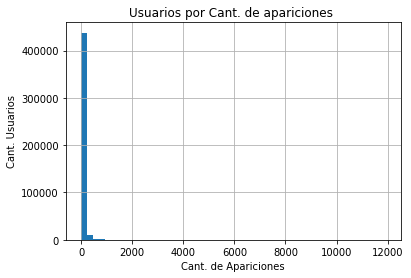

In [5]:
app_dev_id = auctions.groupby(grp, sort=False)['date'].count()
print('Prom. de apariciones de usuarios en 3 dias: ', app_dev_id.mean())
print('Min. de apariciones de usuarios en 3 dias: ', app_dev_id.min())
print('Max. de apariciones de usuarios en 3 dias: ', app_dev_id.max())
print('Med. de apariciones de usuarios en 3 dias: ', app_dev_id.median())
print('Total de Registros: ', app_dev_id.count())

plot = app_dev_id.hist(bins=50)
plot.set_title("Usuarios por Cant. de apariciones ")
plot.set_xlabel("Cant. de Apariciones")
plot.set_ylabel("Cant. Usuarios")

Elimino los que aparecen una sola vez (no se puede estimar tiempo de arribo) y los que aparecen mas de 1000 veces (No tiene sentido, estan muy por arriba de la mediana)

('Prom. de apariciones de usuarios en 3 dias: ', 27.35093602995296)
('Min. de apariciones de usuarios en 3 dias: ', 3)
('Max. de apariciones de usuarios en 3 dias: ', 149)
('Med. de apariciones de usuarios en 3 dias: ', 14.0)
('Total de Registros: ', 312490)


Text(0,0.5,'Cant. Usuarios')

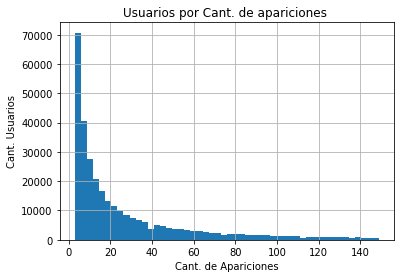

In [6]:
min_value = 2
max_value = 150

#Entre 1 y 1000 quedan 381582 registros 
#Entre 1 y 300 quedan 371666 registros
#Entre 5 y 200 quedan 250549 registros

app_dev_id_filtered = auctions.groupby(grp, sort=False).filter(lambda data: ((len(data) > min_value) & (len(data) < max_value)))
                                                                                                                  
app_dev_id = app_dev_id_filtered.groupby(grp, sort=False)['date'].count()
print('Prom. de apariciones de usuarios en 3 dias: ', app_dev_id.mean())
print('Min. de apariciones de usuarios en 3 dias: ', app_dev_id.min())
print('Max. de apariciones de usuarios en 3 dias: ', app_dev_id.max())
print('Med. de apariciones de usuarios en 3 dias: ', app_dev_id.median())
print('Total de Registros: ', app_dev_id.count())

plot = app_dev_id.hist(bins=50)
plot.set_title("Usuarios por Cant. de apariciones ")
plot.set_xlabel("Cant. de Apariciones")
plot.set_ylabel("Cant. Usuarios")

## Cada 3 dias, cuanto es el tiempo promedio entre apariciones de un dispositivo? 

In [7]:
#con app_dev_id calcular el tiempo entre una apricion y otra aparicion y promediarlo por usuario y luego por total.
app_dev_id_filtered.head()

,date,device_id,platform,ref_type_id,source_id,date_frame
3,2019-03-11 14:18:36.167163,7829815350267792040,1,1,0,0
7,2019-03-11 14:18:42.823963,160071254383181872,1,1,0,0
9,2019-03-11 14:18:44.470248,2960551690927930513,1,1,0,0
10,2019-03-11 14:18:47.603990,6306824739731026067,1,1,0,0
11,2019-03-11 14:18:48.424327,3936313574333788462,1,1,0,0


In [8]:
grouped_ordered = app_dev_id_filtered.groupby(grp, as_index = False, sort=False)\
                                     .apply(lambda x: x.sort_values(by='date', inplace=True))
grouped_ordered.head()

date            device_id platform  \
0 13418629 2019-03-05 02:06:20.204207  7829815350267792040        1   
  16915589 2019-03-05 02:07:14.932974  7829815350267792040        1   
  13891846 2019-03-05 02:07:18.578456  7829815350267792040        1   
  1504792  2019-03-08 14:19:22.474250  7829815350267792040        1   
  197974   2019-03-08 16:21:38.819867  7829815350267792040        1   

           ref_type_id source_id  date_frame  
0 13418629           1         0           0  
  16915589           1         0           0  
  13891846           1         0           0  
  1504792            1         0           0  
  197974             1         2           0

In [9]:
grouped_ordered['next_date'] = grouped_ordered.groupby(grp, as_index = False, sort=False)['date'].transform(lambda x: x.shift(-1))
grouped_ordered = grouped_ordered.loc[(~grouped_ordered['next_date'].isnull())]
grouped_ordered['secs_to_next'] = (grouped_ordered['next_date'] - grouped_ordered['date']).transform(lambda x: round(x.total_seconds(), 2))

KeyboardInterrupt: 

In [ ]:
grouped_ordered.head()

In [ ]:
#Quiero estandarizar los datos y ver si la distribucion es similar en los grupos de 3 dias
grouped_ordered['stn_stn'] = grouped_ordered.groupby('date_frame')['secs_to_next'].transform(lambda x: ((x-x.mean()) / x.std())) 

In [ ]:
grouped_ordered.groupby('date_frame')[['stn_stn', 'secs_to_next']].describe()

Se observa que el 3 percentil se encuentra por abajo de los 500 seg siempre, lo que indica que la mayoria d elas veces un dispositivo aparece varias veces en un tiempo muy acotado y luego desaparece por bastante tiempo hasta que aparece de nuevo.

Se filtran los que tardaron mas de 500 seg.

In [ ]:
grouped_ordered = grouped_ordered.loc[grouped_ordered['secs_to_next'] < 600]

In [ ]:
grouped_ordered.boxplot(by='date_frame', column='stn_stn')

In [ ]:
grouped_ordered.hist(by='date_frame', column='stn_stn', cumulative=True, normed=True)